# Auto Capacitación Python ML
Obj: predicción Anomalías en Compresores

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import datetime

In [3]:
import re

In [ ]:
#!pip install pandas-profiling --upgrade version 3.1.0 2022.01.16
import pandas_profiling as pp

In [28]:
#!pip install composeml
import composeml as cp
import featuretools as ft
# pip install graphviz
#https://graphviz.readthedocs.io/en/stable/examples.html
import graphviz

In [ ]:
#import dtale

In [ ]:
# Seteos de Pandas para ver mejor la info. https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
# In max_columns and max_rows ‘None’ value means unlimited.
pd.set_option('display.max_rows', 100)
# Conviene setear min_rows también porque cuando se superan las max_rows, sólo muestra la cantidad indicada en min_rows.
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.1f}'.format

# Data Import
Como se trata de la importación de los datos para el modelado, no es un trabajo repetitivo, se bajan los datos de PI utilizando datalink. Los datos quedan en un csv que se importa en este notebook.
Como los datos vienen para un mismo timestamp, una columna por elemento (compresor) y tag, se debe hacer una especie de trasposición para que los datos queden utilizables (de datalink el id del compresor viene en el nombre del tag, o sea, en el nombre de la columna y no como un dato en la columna "compresor", se debe agregar esta columna)

In [4]:
path = 'C:\\Users\\COLMO\\data_mining\\1-Curso Python Austral 2021\\1-Material Soporte'

In [5]:
dir = path + '\\data'

In [6]:
file = 'EMA_compresores_5min.csv'

In [7]:
import locale
locale.getlocale()

('Spanish_Argentina', '1252')

In [8]:
# pd.read_csv()'http://files.grouplens.org/datasets/movielens/ml-100k/u.item', sep='|', names=m_cols, usecols=range(5), 
# encoding='windows-1251' o 'UTF-8')
df_comp = pd.read_csv(dir + '\\' + file, sep=';', encoding='windows-1251').rename(columns={'Unnamed: 0': 'timestamp'})
df_comp.columns = df_comp.columns.str.lower()
df_comp.shape

(39503, 46)

In [11]:
df_comp.head()

timestamp k-01_comp_rpm k-01_em_carga_motriz  \
0  31-ago-21 18:00:00   1173,366211          97,75390625   
1  31-ago-21 18:05:00   1173,895508          97,02148438   
2  31-ago-21 18:10:00   1173,163452          96,77734375   
3  31-ago-21 18:15:00   1172,869263             97,65625   
4  31-ago-21 18:20:00   1173,551025               96,875   

  k-01_presion_descarga 1y3 k-01_presion_descarga 2y4 k-01_presion_succion  \
0                89,3755722               90,52375793          34,26144409   
1                89,3755722               90,31398773          34,26144409   
2                89,3755722               90,31398773          34,26144409   
3               89,15753937               90,31398773          34,26144409   
4               88,22463989                89,5825882          34,26144409   

  k-02_comp_rpm k-02_em_carga_motriz k-02_presion_descarga 1y3  \
0   1158,735596            97,265625               89,64330292   
1   1158,437256          96,92382813               89,64330292   
2   1158,923462            97,265625               89,64330292   
3   1158,442505          97,16796875               89,64330292   
4   1158,576416          96,53320313               88,66624451   

  k-02_presion_descarga 2y4  ... k-08_comp_rpm k-08_em_carga_motriz  \
0                90,2284317  ...   1158,759155          95,06835938   
1                90,2284317  ...   1158,908936          95,36132813   
2                90,2284317  ...   1158,001343          94,62890625   
3                90,2284317  ...   1160,113892          95,55664063   
4                89,2872467  ...   1158,426514            95,703125   

  k-08_presion_descarga 1y3 k-08_presion_descarga 2y4 k-08_presion_succion  \
0                       Bad                       Bad          34,46625137   
1                       Bad                       Bad          34,26281357   
2                       Bad                       Bad          34,26281357   
3                       Bad                       Bad          34,26281357   
4                       Bad                       Bad          34,26281357   

  k-09_comp_rpm k-09_em_carga_motriz k-09_presion_descarga 1y3  \
0   1161,573853          90,86914063               18,59043121   
1    1160,57251          90,57617188               18,29234505   
2   1158,709961           90,8203125               18,29234505   
3    1159,77063          91,11328125               18,29234505   
4   1160,420654          91,11328125               18,29234505   

  k-09_presion_descarga 2y4 k-09_presion_succion  
0               36,26360321           6,88760376  
1               36,05715179           6,88760376  
2               36,05715179           6,88760376  
3               36,05715179           6,88760376  
4               36,05715179           6,88760376  

[5 rows x 46 columns]

In [8]:
# Estructura del nombre de tags esperada: K-01_COMP_RPM

In [9]:
# Necesito obtener el listado de compresores: splitteo por el caracter "_", tomo sólo el primer elemento splitteado, busco los uniques (set)
# convierto el set en lista:
element_lst = list(set([re.split("_", x)[0] for x in df_comp.columns[1:]]))
element_lst.sort() # Ordena in place y devuelve nan por eso se debe poner abajo que lo muestre.
element_lst

['k-01', 'k-02', 'k-03', 'k-04', 'k-05', 'k-06', 'k-07', 'k-08', 'k-09']

In [10]:
# Listado de tags
tag_lst = list(set([re.split("_", x, maxsplit=1)[1] for x in df_comp.columns[1:]]))
tag_lst

['presion_succion',
 'presion_descarga 2y4',
 'comp_rpm',
 'em_carga_motriz',
 'presion_descarga 1y3']

In [11]:
keys = [element_lst[0]+'_'+x for x in tag_lst]
values = [x for x in tag_lst]
dict(zip(keys, values))

{'k-01_presion_succion': 'presion_succion',
 'k-01_presion_descarga 2y4': 'presion_descarga 2y4',
 'k-01_comp_rpm': 'comp_rpm',
 'k-01_em_carga_motriz': 'em_carga_motriz',
 'k-01_presion_descarga 1y3': 'presion_descarga 1y3'}

In [12]:
print(element_lst[0]+'_'+tag_lst[0])
df_list = []
for element in element_lst:
    df_aux_columns = ['timestamp']
    for tag in tag_lst:
        df_aux_columns.append(element+'_'+tag)
    keys = [element+'_'+x for x in tag_lst]
    values = [x for x in tag_lst]
    rename_col_dict = dict(zip(keys, values))
    df_aux = df_comp[df_aux_columns].rename(columns=rename_col_dict)
    df_aux['element'] = element
    df_list.append(df_aux)
df_hist = pd.concat(df_list, ignore_index=True)
df_hist.tail()

k-01_presion_succion


timestamp presion_succion presion_descarga 2y4   comp_rpm  \
355522  15-ene-22 21:30:00       Comm Fail            Comm Fail  Comm Fail   
355523  15-ene-22 21:35:00       Comm Fail            Comm Fail  Comm Fail   
355524  15-ene-22 21:40:00       Comm Fail            Comm Fail  Comm Fail   
355525  15-ene-22 21:45:00       Comm Fail            Comm Fail  Comm Fail   
355526  15-ene-22 21:50:00       Comm Fail            Comm Fail  Comm Fail   

       em_carga_motriz presion_descarga 1y3 element  
355522       Comm Fail            Comm Fail    k-09  
355523       Comm Fail            Comm Fail    k-09  
355524       Comm Fail            Comm Fail    k-09  
355525       Comm Fail            Comm Fail    k-09  
355526       Comm Fail            Comm Fail    k-09

In [38]:
file = 'EMA_compresores_diario_zafiro.csv'
# Bajada de SQL con estas columnas: 
# equipment_id, Equipo, Dia_Operativo, Comentarios, Estado, Mantenimiento_Programado, Mantenimiento_No_Programado, En_Reserva, En_Marcha,
# Rpm, facility_eqp_parameter_energy_generation, Presion_Succion, Presion_Descarga, Temperatura_Succion, Temperatura_Descarga, Caudal,
# es_overhaul

In [39]:
# 'windows-1251' UTF-8 trae bien los caracteres especiales del castellano
df_diario = pd.read_csv(dir + '\\' + file, sep=';', encoding='UTF-8', index_col=False,
                        names=['equipment_id', 'element', 'timestamp', 'comments', 'estado', 'mant_prog', 'mant_no_prog', 
                               'en_reserva', 'en_marcha', 'rpm', 'facility_eqp_parameter_energy_generation', 
                               'press_succ', 'press_desc', 'temp_succ', 'temp_desc', 'caudal', 'es_overhaul'])
df_diario = df_diario[df_diario.element.str.lower().isin(element_lst)]
df_diario.shape

(3410, 17)

In [40]:
df_diario.tail()

equipment_id element                timestamp  \
4516           116    K-09  2022-01-10 00:00:00.000   
4517           116    K-09  2022-01-11 00:00:00.000   
4518           116    K-09  2022-01-12 00:00:00.000   
4519           116    K-09  2022-01-13 00:00:00.000   
4520           116    K-09  2022-01-14 00:00:00.000   

                                               comments             estado  \
4516  E/S por limpieza de filtros de succion K-04/06...  En Funcionamiento   
4517                                                NaN  En Funcionamiento   
4518   paro alta presión de succ. de 1er etapa / alt...  En Funcionamiento   
4519  12:20 hs, Se deja equipo E/R. Personal de Mtto...  En Funcionamiento   
4520                09:10 hs E/R. 03:15 a 04:30 hs E/S          En Reserva   

     mant_prog mant_no_prog en_reserva en_marcha    rpm  \
4516         0            0       15,6       8,4   1160   
4517         0            0          0        24   1160   
4518         0          4,4          0      19,6  10500   
4519         0            0       12,2      11,8   1100   
4520         0            0       19,5       4,5      0   

      facility_eqp_parameter_energy_generation press_succ press_desc  \
4516                                       NaN        6,3       36,7   
4517                                       NaN        7,2       36,7   
4518                                       NaN        6,2       36,1   
4519                                       NaN        6,4       35,4   
4520                                       NaN          0          0   

     temp_succ temp_desc  caudal  es_overhaul  
4516       NaN       115     NaN          0.0  
4517      22,1     110,8     NaN          0.0  
4518        22       112     NaN          0.0  
4519      22,6     105,9     NaN          0.0  
4520         0         0     NaN          0.0

In [177]:
df_diario.comments.unique()[:4]

array([nan,
       'Se produce Paro por Muy Alta t° Cil. 6 izq., en cuatro oportunidades. Se deja E/S nuevamente con 1100 rpm. Se para de 01:25 a 01:55 hs por misma causa y se cambia bujía de dicho cilindro.',
       '10:00 hs a 11:45 hs, Paro de equipo Mtto cambia termocupla en Cil.Motor # 6 izq.- ',
       'Planta Ema, 15:00 hs a 16:20 hs Paro por Detección de llama Zona Compresor K-02.Se cierran pozos y se comienza con apertura de los mismo.-'],
      dtype=object)

# EDA con Pandas Profiling
https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/

In [126]:
#pp.ProfileReport(df_hist)

In [41]:
pp.ProfileReport(df_diario)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Data Wrangling
Toma a todas las variables como categóricas --> asignarles un tipo <br>



### Regex 101
https://regex101.com/r/vU4vF1/1

## Dataset de Tiempo Real (PI)

In [13]:
# Se renombran columnas para facilidad de uso
df_hist.rename(columns={'presion_descarga 1y3': 'press_1', 'presion_succion': 'press_suc', 'presion_descarga 2y4': 'press_2', 
                       'comp_rpm': 'rpm', 'em_carga_motriz': 'carga_motriz'}, inplace=True)

In [14]:
#df_hist.timestamp.replace(r"\d{2}-ago-\d{4} \d{2}:\d{2}:\d{2}", r"\d{2}-aug-\d{4} \d{2}:\d{2}:\d{2}", inplace=True, regex=True)
#datetime.datetime.strptime('31-aug-21 18:00:00', '%d-%b-%y %H:%M:%S')
df_hist.timestamp = df_hist.timestamp.str.replace('ago', 'aug')
df_hist.timestamp = df_hist.timestamp.str.replace('ene', 'jan')
df_hist.timestamp = df_hist.timestamp.str.replace('abr', 'apr')
df_hist.timestamp = df_hist.timestamp.str.replace('ago', 'aug')
df_hist.timestamp = df_hist.timestamp.str.replace('dic', 'dec')
#df_hist.timestamp.astype('datetime64' , copy=False)
# https://docs.python.org/3.7/library/datetime.html#strftime-strptime-behavior
df_hist.timestamp = pd.to_datetime(df_hist.timestamp, dayfirst=True, format='%d-%b-%y %H:%M:%S')
df_hist.head()

timestamp    press_suc      press_2          rpm carga_motriz  \
0 2021-08-31 18:00:00  34,26144409  90,52375793  1173,366211  97,75390625   
1 2021-08-31 18:05:00  34,26144409  90,31398773  1173,895508  97,02148438   
2 2021-08-31 18:10:00  34,26144409  90,31398773  1173,163452  96,77734375   
3 2021-08-31 18:15:00  34,26144409  90,31398773  1172,869263     97,65625   
4 2021-08-31 18:20:00  34,26144409   89,5825882  1173,551025       96,875   

       press_1 element  
0   89,3755722    k-01  
1   89,3755722    k-01  
2   89,3755722    k-01  
3  89,15753937    k-01  
4  88,22463989    k-01

In [57]:
for column in df_hist.columns[1:-1]:
    print(df_hist[column].head(1))

0    89,3755722
Name: press_1, dtype: object
0    34,26144409
Name: press_suc, dtype: object
0    90,52375793
Name: press_2, dtype: object
0    1173,366211
Name: rpm, dtype: object
0    97,75390625
Name: carga_motriz, dtype: object


### OJO: las columnas de valores tienen valores tales como: bad o comm fail


In [15]:
# El .astype no reconoce como float a los strings con "," --> reemplazo por "."
# Los valores Bad, Comm Fail y I/O Timeout hay que convertirlos a numéricos. NO tengo claro cómo conviene "labelearlos", por ahora,
# los convierto a un número negativo
for column in df_hist.columns[1:-1]:
    df_hist[column] = df_hist[column].str.replace(',', '.')
    df_hist[column] = df_hist[column].str.replace('Bad', '-1')
    df_hist[column] = df_hist[column].str.replace('Comm Fail', '-2')
    df_hist[column] = df_hist[column].str.replace('I/O Timeout', '-3')
    df_hist[column] = df_hist[column].astype('float64' , copy=True)
print(df_hist.dtypes)
df_hist.head()

timestamp       datetime64[ns]
press_suc              float64
press_2                float64
rpm                    float64
carga_motriz           float64
press_1                float64
element                 object
dtype: object


timestamp  press_suc    press_2          rpm  carga_motriz  \
0 2021-08-31 18:00:00  34.261444  90.523758  1173.366211     97.753906   
1 2021-08-31 18:05:00  34.261444  90.313988  1173.895508     97.021484   
2 2021-08-31 18:10:00  34.261444  90.313988  1173.163452     96.777344   
3 2021-08-31 18:15:00  34.261444  90.313988  1172.869263     97.656250   
4 2021-08-31 18:20:00  34.261444  89.582588  1173.551025     96.875000   

     press_1 element  
0  89.375572    k-01  
1  89.375572    k-01  
2  89.375572    k-01  
3  89.157539    k-01  
4  88.224640    k-01

In [23]:
#df_comp = pd.read_csv(dir + '\\' + file, sep=';', encoding='windows-1251').rename(columns={'Unnamed: 0': 'timestamp'})
output_file = 'EMA_compresores_5min_ok.csv'
#df_hist.iloc[:10] Para filtar los 10 primeros
df_hist[df_hist.element=='k-09'].to_csv(dir + '\\' + output_file, sep=';', encoding='UTF-8', decimal = '.') #  'windows-1251'

In [64]:
pp.ProfileReport(df_hist)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [147]:
df_diario.head()

equipment_id element                timestamp comments             estado  \
0        п»ї25    K-01  2021-01-01 00:00:00.000      NaN  En Funcionamiento   
1           25    K-01  2021-01-02 00:00:00.000      NaN  En Funcionamiento   
2           25    K-01  2021-01-03 00:00:00.000      NaN  En Funcionamiento   
3           25    K-01  2021-01-04 00:00:00.000      NaN  En Funcionamiento   
4           25    K-01  2021-01-05 00:00:00.000      NaN  En Funcionamiento   

  mant_prog mant_no_prog en_reserva en_marcha   rpm  \
0         0            0          0        24  1170   
1         0            0          0        24  1170   
2         0            0          0        24  1165   
3         0            0          0        24  1165   
4         0            0          0        24  1165   

   facility_eqp_parameter_energy_generation press_succ press_desc temp_succ  \
0                                       NaN       31,6       85,5      23,4   
1                                       NaN       31,5       85,9      23,3   
2                                       NaN       31,9         88      25,9   
3                                       NaN       30,1       85,3      25,3   
4                                       NaN       32,6       85,3      25,5   

  temp_desc  caudal  es_overhaul  
0     115,7     NaN          NaN  
1     115,8     NaN          NaN  
2       112     NaN          NaN  
3     112,8     NaN          NaN  
4       107     NaN          NaN

In [ ]:
#df_diario.timestamp = pd.to_datetime(df_hist.timestamp, dayfirst=True, format='%d-%b-%y %H:%M:%S')

In [154]:
# https://realpython.com/nltk-nlp-python/ nltk para Natural processing language de los comentarios y obtener cuándo se trata de un paro.

# Dataset Tiempo Real Pozo

In [27]:
path = 'C:\\Users\\COLMO\\data_mining\\1-Curso Python Austral 2021\\1-Material Soporte'

In [28]:
dir = path + '\\data'

In [29]:
file = 'EMA_1063.csv'

In [71]:
# pd.read_csv()'http://files.grouplens.org/datasets/movielens/ml-100k/u.item', sep='|', names=m_cols, usecols=range(5), 
# encoding='windows-1251' o 'UTF-8')
df_well = pd.read_csv(dir + '\\' + file, sep=';', encoding='windows-1251')
df_well.columns = df_well.columns.str.lower()
df_well.rename(columns={'Unnamed: 0': 'timestamp', 'm-1063(d)_ft_0121': 'caudal', 'm-1063(d)_fqa_0121': 'acum_ayer',
                        'm-1063(d)_fq_0121': 'acum_hoy', 'm-1063(d)_pit_0111': 'presion_boca', 
                        'm-1063(d)_pt_0121': 'presion_linea', 'm-1063(d)_tit_0111': 'temp_boca', 
                        'm-1063(d)_tt_0121': 'temp_linea'}, inplace=True)
df_well = df_well[df_well.timestamp.notna()][['timestamp', 'caudal', 'acum_ayer', 'acum_hoy', 'presion_boca', 'presion_linea', 
                   'temp_boca', 'temp_linea']]

In [72]:
print('shape:', df_well.shape)
print(df_well.columns)
print(df_well.dtypes)
df_well.head()

shape: (26662, 8)
Index(['timestamp', 'caudal', 'acum_ayer', 'acum_hoy', 'presion_boca',
       'presion_linea', 'temp_boca', 'temp_linea'],
      dtype='object')
timestamp        object
caudal           object
acum_ayer        object
acum_hoy         object
presion_boca     object
presion_linea    object
temp_boca        object
temp_linea       object
dtype: object


timestamp       caudal   acum_ayer     acum_hoy presion_boca  \
0  20-ene-21 13:00:00  444,2568665  7,57330513  4,925503731  36,01953506   
1  20-ene-21 13:20:00  434,2290344  7,57330513  10,97051334  36,01953506   
2  20-ene-21 13:40:00  437,7449646  7,57330513    17,015522  36,14163589   
3  20-ene-21 14:00:00   439,645752  7,57330513  23,06053162  36,14163589   
4  20-ene-21 14:20:00  431,8800659  7,57330513  29,10554123  36,14163589   

  presion_linea    temp_boca   temp_linea  
0   0,385910243  37,36032486  33,13892365  
1   0,385910243  38,47543335  34,07740021  
2   0,385910243  38,88611221  34,22776031  
3   0,385910243  39,29678726  34,37811661  
4   0,385910243  40,31896591  34,52847672

In [73]:
#df_hist.timestamp.replace(r"\d{2}-ago-\d{4} \d{2}:\d{2}:\d{2}", r"\d{2}-aug-\d{4} \d{2}:\d{2}:\d{2}", inplace=True, regex=True)
#datetime.datetime.strptime('31-aug-21 18:00:00', '%d-%b-%y %H:%M:%S')
df_well.timestamp = df_well.timestamp.str.replace('ago', 'aug')
df_well.timestamp = df_well.timestamp.str.replace('ene', 'jan')
df_well.timestamp = df_well.timestamp.str.replace('abr', 'apr')
df_well.timestamp = df_well.timestamp.str.replace('ago', 'aug')
df_well.timestamp = df_well.timestamp.str.replace('dic', 'dec')
# https://docs.python.org/3.7/library/datetime.html#strftime-strptime-behavior
df_well.timestamp = pd.to_datetime(df_well.timestamp, dayfirst=True, format='%d-%b-%y %H:%M:%S')
df_well.tail()

timestamp       caudal    acum_ayer     acum_hoy presion_boca  \
26657 2022-01-25 18:40:00  270,7416382  276,3100586  145,7837677  31,44078064   
26658 2022-01-25 19:00:00  268,9707336  276,3100586  149,5336914  30,89133072   
26659 2022-01-25 19:20:00  283,3686218  276,3100586  153,2836151  31,19658089   
26660 2022-01-25 19:40:00  256,2748413  276,3100586  157,0335388  31,56288147   
26661 2022-01-25 20:00:00  270,6828613  276,3100586  160,7834625  31,31868172   

      presion_linea    temp_boca   temp_linea  
26657    30,6060276   41,7293396  41,09983826  
26658   30,21727753  41,70121384  41,09315491  
26659   30,52560806  40,94379807  40,96773911  
26660   31,03915215  40,50896835  40,75102615  
26661   30,75515175   40,2545929  40,53431702

In [74]:
# El .astype no reconoce como float a los strings con "," --> reemplazo por "."
# Los valores Bad, Comm Fail y I/O Timeout hay que convertirlos a numéricos. NO tengo claro cómo conviene "labelearlos", por ahora,
# los convierto a un número negativo
for column in df_well.columns[1:]:
    df_well[column] = df_well[column].str.replace(',', '.')
    df_well[column] = df_well[column].str.replace('Bad', '-1')
    df_well[column] = df_well[column].str.replace('Comm Fail', '-2')
    df_well[column] = df_well[column].str.replace('I/O Timeout', '-3')
    df_well[column] = df_well[column].astype('float64' , copy=True)
print(df_well.dtypes)
df_well.head()

timestamp        datetime64[ns]
caudal                  float64
acum_ayer               float64
acum_hoy                float64
presion_boca            float64
presion_linea           float64
temp_boca               float64
temp_linea              float64
dtype: object


timestamp      caudal  acum_ayer   acum_hoy  presion_boca  \
0 2021-01-20 13:00:00  444.256867   7.573305   4.925504     36.019535   
1 2021-01-20 13:20:00  434.229034   7.573305  10.970513     36.019535   
2 2021-01-20 13:40:00  437.744965   7.573305  17.015522     36.141636   
3 2021-01-20 14:00:00  439.645752   7.573305  23.060532     36.141636   
4 2021-01-20 14:20:00  431.880066   7.573305  29.105541     36.141636   

   presion_linea  temp_boca  temp_linea  
0        0.38591  37.360325   33.138924  
1        0.38591  38.475433   34.077400  
2        0.38591  38.886112   34.227760  
3        0.38591  39.296787   34.378117  
4        0.38591  40.318966   34.528477

In [75]:
output_file = 'EMA_well_1063_20min_ok.csv'
#df_hist.iloc[:10] Para filtar los 10 primeros
df_well.to_csv(dir + '\\' + output_file, sep=';', encoding='UTF-8', decimal = '.') #  'windows-1251'

## Dataset de Datos Diarios (Zafiro)

In [45]:
df_diario.columns

Index(['equipment_id', 'element', 'timestamp', 'comments', 'estado',
       'mant_prog', 'mant_no_prog', 'en_reserva', 'en_marcha', 'rpm',
       'facility_eqp_parameter_energy_generation', 'press_succ', 'press_desc',
       'temp_succ', 'temp_desc', 'caudal', 'es_overhaul'],
      dtype='object')

In [46]:
df_diario.dtypes

equipment_id                                  int64
element                                      object
timestamp                                    object
comments                                     object
estado                                       object
mant_prog                                    object
mant_no_prog                                 object
en_reserva                                   object
en_marcha                                    object
rpm                                          object
facility_eqp_parameter_energy_generation    float64
press_succ                                   object
press_desc                                   object
temp_succ                                    object
temp_desc                                    object
caudal                                      float64
es_overhaul                                 float64
dtype: object

In [47]:
# timestamp
#print(pd.to_datetime('2021-08-15 00:00:00.000', dayfirst=True, format='%Y-%m-%d %H:%M:%S'))
df_diario.timestamp = pd.to_datetime(df_diario.timestamp, format='%Y-%m-%d %H:%M:%S')

In [48]:
# comments: 
print('Los comentarios Nan se convierten a Sin Novedades', df_diario.comments.isna().sum()) #2573
df_diario.comments.fillna('Sin Novedades', inplace=True)

Los comentarios Nan se convierten a Sin Novedades 2573


In [49]:
# Los datos tipo float vienen con ',' como separador decimal. Se reemplaza por '.' para poder convertir a float
# lista de campos tipo float:
columns = list(df_diario.columns[5:10]) + list(df_diario.columns[11:-2])
print(columns)
for column in columns:
    df_diario[column] = df_diario[column].str.replace(',', '.')
    df_diario[column] = df_diario[column].astype('float64' , copy=True)
print(df_diario.dtypes)
df_diario.head()

['mant_prog', 'mant_no_prog', 'en_reserva', 'en_marcha', 'rpm', 'press_succ', 'press_desc', 'temp_succ', 'temp_desc']
equipment_id                                         int64
element                                             object
timestamp                                   datetime64[ns]
comments                                            object
estado                                              object
mant_prog                                          float64
mant_no_prog                                       float64
en_reserva                                         float64
en_marcha                                          float64
rpm                                                float64
facility_eqp_parameter_energy_generation           float64
press_succ                                         float64
press_desc                                         float64
temp_succ                                          float64
temp_desc                                          float

equipment_id element  timestamp       comments             estado  \
0            25    K-01 2021-01-01  Sin Novedades  En Funcionamiento   
1            25    K-01 2021-01-02  Sin Novedades  En Funcionamiento   
2            25    K-01 2021-01-03  Sin Novedades  En Funcionamiento   
3            25    K-01 2021-01-04  Sin Novedades  En Funcionamiento   
4            25    K-01 2021-01-05  Sin Novedades  En Funcionamiento   

   mant_prog  mant_no_prog  en_reserva  en_marcha     rpm  \
0        0.0           0.0         0.0       24.0  1170.0   
1        0.0           0.0         0.0       24.0  1170.0   
2        0.0           0.0         0.0       24.0  1165.0   
3        0.0           0.0         0.0       24.0  1165.0   
4        0.0           0.0         0.0       24.0  1165.0   

   facility_eqp_parameter_energy_generation  press_succ  press_desc  \
0                                       NaN        31.6        85.5   
1                                       NaN        31.5        85.9   
2                                       NaN        31.9        88.0   
3                                       NaN        30.1        85.3   
4                                       NaN        32.6        85.3   

   temp_succ  temp_desc  caudal  es_overhaul  
0       23.4      115.7     NaN          NaN  
1       23.3      115.8     NaN          NaN  
2       25.9      112.0     NaN          NaN  
3       25.3      112.8     NaN          NaN  
4       25.5      107.0     NaN          NaN

#### Entendiendo la relación entre los valores de parámetros (rpm, cuadal, etc) con el estado
Se llega a la conclusión de NO utilizar estos parámetros (tenemos los datos en el PI) Porque se tiene el dato cantidad de horas en un día, pero no se indica a qué hora del día corresponde --> no se lo puede asociar al dataset de PI.<br>
Se vá a asociar al dataset de PI a través del estado diario

* Estado<br>

* Horas <br>
> * Mantenimiento Programado
> * Mantenimiento No Programado
> * En Reserva
> * En Marcha

In [26]:
# rpm missing in 126 rows --> No se corrigen porque no se utilizarán estos datos.
#df_diario[df_diario.rpm.isna()].tail()

In [27]:
df_diario[df_diario.mant_no_prog > 0].groupby(['element']).agg({'mant_no_prog':['count','sum']})

mant_no_prog       
               count    sum
element                    
K-01              14   20.8
K-02              20   50.5
K-03              16   40.7
K-04              60  131.8
K-05              64  156.5
K-06              54  185.4
K-07              53  102.1
K-08              39   83.0
K-09              67  200.3

In [28]:
df_diario[df_diario.en_reserva > 0].groupby(['element']).agg({'en_reserva':['count','sum']})

en_reserva       
             count    sum
element                  
K-01             6   32.2
K-02             6   36.3
K-03             6   33.4
K-04            14   54.0
K-05            47  665.2
K-06            27  387.5
K-07            16  181.4
K-08             7   40.2
K-09            39  513.7

In [35]:
# OJO: el equipo puede tener horas en reserva, pero el estado ser otro, ej: En Funcionamiento
df_diario[(df_diario.element=='K-01') & (df_diario.en_reserva>0)]

equipment_id element  timestamp  \
31             25    K-01 2021-02-01   
118            25    K-01 2021-04-29   
119            25    K-01 2021-04-30   
126            25    K-01 2021-05-07   
189            25    K-01 2021-07-09   
260            25    K-01 2021-09-18   

                                              comments             estado  \
31   Planta Ema, 15:00 hs a 16:20 hs Paro por Detec...  En Funcionamiento   
118                     05:00 hs E/R para Paro de Pta.         En Reserva   
119                                      Sin Novedades  En Funcionamiento   
126                                     Paro de Planta  En Funcionamiento   
189   Paro de PTG por Falla en Interruptor de CCM CBP   En Funcionamiento   
260                                   Paro de PTG ESD1  En Funcionamiento   

     mant_prog  mant_no_prog  en_reserva  en_marcha     rpm  \
31         0.0           0.0         2.0       22.0  1160.0   
118        0.0           0.0         1.0       23.0     NaN   
119        0.0           0.0        22.5        1.5  1150.0   
126        0.0           0.3         5.4       18.3  1170.0   
189        0.0           0.0         0.6       23.4  1160.0   
260        0.0           0.0         0.7       23.3  1160.0   

     facility_eqp_parameter_energy_generation  press_succ  press_desc  \
31                                        NaN        30.9        84.3   
118                                       NaN         NaN         NaN   
119                                       NaN        31.3        81.9   
126                                       NaN        32.9        85.2   
189                                       NaN        33.1        90.0   
260                                       NaN        34.9        92.1   

     temp_succ  temp_desc  caudal  es_overhaul  
31        21.8      115.5     NaN          NaN  
118        NaN        NaN     NaN          NaN  
119       24.3      105.4     NaN          NaN  
126       19.0      112.0     NaN          NaN  
189       16.4      115.5     NaN          NaN  
260       18.3      111.6     NaN          NaN

# Prueba del Framework ComposeML + FeatureTools + AutoML
Sigo el ejemplo de "predict next purchase" https://compose.alteryx.com/en/stable/examples/predict_next_purchase.html de ComposeML. <br>

_**Objetivo:**_ predecir con 1 semana de anticipación si se vá a producir un día con mantenimiento no programado.

## Prediction Engineering con ComposeML
Creating our own labels on the data <br>
Package composeml https://compose.alteryx.com/en/stable/start.html

In [50]:
# 1-Defining the Labeling Function
def mant_no_prog(df):
    # hs_mant_no_prog = df['mant_no_prog'] # Podría ser directamente la cantidad de horas de mantenimiento no programado de un 1.
    # AL poner sum() creo que, si luego se cambia la ventana de tiempo, funcionaría igual.
    hs_mant_no_prog = df['mant_no_prog'].sum()
    return hs_mant_no_prog

In [52]:
# 2-Construct Label Maker
# With the labeling function, create the LabelMaker for this prediction problem. 
# To process one day of operations for each equipment, set the target_entity to the equipment_id and the window_size to 1 day
label_maker = cp.LabelMaker(
    target_entity="element",
    time_index="timestamp",
    labeling_function=mant_no_prog,
    window_size="1d",
)

In [53]:
# 3-Generate Labels
# Automatically search and extract the labels using LabelMaker.search()
# https://compose.alteryx.com/en/stable/generated/methods/composeml.LabelMaker.search.html#composeml.LabelMaker.search
labels = label_maker.search(
    df_diario.sort_values('timestamp'),
    num_examples_per_instance=-1, #to find the number of training examples per customer. -1 =the search returns all existing examples.
    gap=1,
    verbose=True,
)

Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|█████████████████████████████████████████████████████| element: 9/9 


In [54]:
labels.head()

element       time  mant_no_prog
0    K-01 2021-01-01           0.0
1    K-01 2021-01-02           0.0
2    K-01 2021-01-03           0.0
3    K-01 2021-01-04           0.0
4    K-01 2021-01-05           0.0

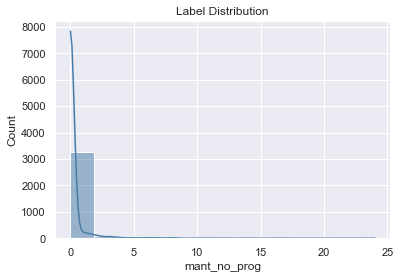

In [55]:
%matplotlib inline
plot = labels.plot.dist()

In [56]:
# 4-Apply Threshold on Labels
# To make the labels binary, LabelTimes.threshold() is applied for hours exceeding 0 --> indicando que ese día tuvieron mant no programado
labels = labels.threshold(0)
labels.head()

element       time  mant_no_prog
0    K-01 2021-01-01         False
1    K-01 2021-01-02         False
2    K-01 2021-01-03         False
3    K-01 2021-01-04         False
4    K-01 2021-01-05         False

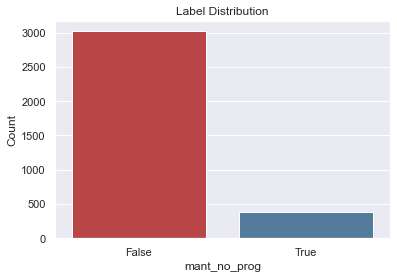

In [57]:
plot = labels.plot.distribution()

In [58]:
# Ahora, el dataframe labels no tiene la cantidad de horas de mantenimiento no prog sino un valor "categórico" indicando 
# si tuvo horas # de mant no programado o no, por eso, haciendo sum() suma la cantidad de días con mant no prog
labels.groupby(['element']).mant_no_prog.sum()

element
K-01    14
K-02    20
K-03    16
K-04    60
K-05    64
K-06    54
K-07    53
K-08    39
K-09    67
Name: mant_no_prog, dtype: int64

In [59]:
# 5-Lead Label Times
# The label times are shifted 7 days earlier for predicting in advance by using LabelTimes.apply_lead().
labels = labels.apply_lead('7d')
labels.head()

element       time  mant_no_prog
0    K-01 2020-12-25         False
1    K-01 2020-12-26         False
2    K-01 2020-12-27         False
3    K-01 2020-12-28         False
4    K-01 2020-12-29         False

In [60]:
# 6-Resumen del trabajo realizado
labels.describe()

Label Distribution
------------------
False     3023
True       387
Total:    3410


Settings
--------
gap                                     1
maximum_data                         None
minimum_data                         None
num_examples_per_instance              -1
target_column                mant_no_prog
target_entity                     element
target_type                      discrete
window_size                            1d


Transforms
----------
1. threshold
  - value:    0

2. apply_lead
  - value:    7d



## Feature Engineering con Featuretools
Getting Started de Featuretools (ojo que cambió mucho en las últimas versiones!!)
https://featuretools.alteryx.com/en/stable/getting_started/using_entitysets.html <br>
_**EntitySet:**_ This method associates each column in the dataframe to a Woodwork logical type. Each logical type can have an associated standard semantic tag that helps define the column data type. If you don’t specify the logical type for a column, it gets inferred based on the underlying data. The logical types and semantic tags are listed in the schema of the dataframe. For more information on working with logical types and semantic tags, take a look at the Woodwork documention.https://woodwork.alteryx.com/en/stable/

Tutorial: Predicción de la próxima compra - https://github.com/alteryx/open_source_demos/blob/main/predict-next-purchase/Tutorial.ipynb

In [62]:
df_diario.columns

Index(['equipment_id', 'element', 'timestamp', 'comments', 'estado',
       'mant_prog', 'mant_no_prog', 'en_reserva', 'en_marcha', 'rpm',
       'facility_eqp_parameter_energy_generation', 'press_succ', 'press_desc',
       'temp_succ', 'temp_desc', 'caudal', 'es_overhaul'],
      dtype='object')

In [63]:
# 1-Create the entity set
# https://featuretools.alteryx.com/en/stable/getting_started/using_entitysets.html
# Start by representing the data with an entity set. That way, you can generate features 
# based on the relational structure of the dataset.
es = ft.EntitySet(id='daily_op')

# Entidad: operación diaria
es = es.add_dataframe(
    dataframe_name="df_diario",
    dataframe=df_diario[['equipment_id', 'element', 'timestamp', 'estado',
       'mant_prog', 'mant_no_prog', 'en_reserva', 'en_marcha']].sort_values(by='timestamp'),
    index="id",
    time_index="timestamp",
    # Lo siguiente, no funciona
    #logical_types={
    #    "estado": Categorical
    #}
)
es

Entityset: daily_op
  DataFrames:
    df_diario [Rows: 3410, Columns: 9]
  Relationships:
    No relationships

In [64]:
# Para ver el esquema woodwork:
es["df_diario"].ww.schema

Logical Type Semantic Tag(s)
Column                                   
id                Integer       ['index']
equipment_id      Integer     ['numeric']
element       Categorical    ['category']
timestamp        Datetime  ['time_index']
estado        Categorical    ['category']
mant_prog          Double     ['numeric']
mant_no_prog       Double     ['numeric']
en_reserva         Double     ['numeric']
en_marcha          Double     ['numeric']

In [65]:
# Entidad: equipos, surge de la normalización del campo element del dataset original.
es = es.normalize_dataframe(
    base_dataframe_name="df_diario",
    new_dataframe_name="equipment",
    index="element",
    #make_time_index="session_start",
    make_time_index=False,
#    additional_columns=[
#        "device",
#        "customer_id",
#        "zip_code",
#        "session_start",
#        "join_date",
#    ],
)
# identifica relaciones automáticamente, en caso de requerir agregar una relación, se usa:
# es = es.add_relationship("products", "product_id", "transactions", "product_id")
es

Entityset: daily_op
  DataFrames:
    df_diario [Rows: 3410, Columns: 9]
    equipment [Rows: 9, Columns: 1]
  Relationships:
    df_diario.element -> equipment.element

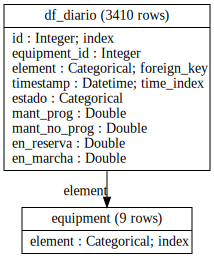

In [66]:
# Volver a probar porque se agregó una variable de entorno y no la toma
es.plot()

In [71]:
# 2-Feature Engineering automático
# https://featuretools.alteryx.com/en/stable/getting_started/afe.html
# https://featuretools.alteryx.com/en/stable/getting_started/primitives.html
# You can generate features by using Deep Feature Synthesis (DFS). Stacks and applies mathematical operations called primitives 
# across relationships in an entity set. DFS generates feature engineering on relational and temporal data.
# average time between events: by stacking two primitives "time_since_previous" and "mean"
feature_matrix, feature_defs = ft.dfs(entityset=es,
                    target_dataframe_name="equipment", # parece que hay que poner la entidad por la que se quiere agrupar
                    agg_primitives=["mean"],
                    trans_primitives=["time_since_previous"],
                    features_only=False, # True = no calcula, sólo muestra los features que va a calcular
                    )
feature_matrix

MEAN(df_diario.en_marcha)  MEAN(df_diario.en_reserva)  \
element                                                          
K-01                     23.444591                    0.084960   
K-09                     21.335884                    1.355409   
K-02                     23.348549                    0.095778   
K-04                     23.233333                    0.142857   
K-07                     22.131926                    0.478628   
K-06                     22.335356                    1.022427   
K-08                     23.387335                    0.106069   
K-03                     23.363061                    0.088127   
K-05                     21.003694                    1.755145   

         MEAN(df_diario.equipment_id)  MEAN(df_diario.mant_no_prog)  \
element                                                               
K-01                             25.0                      0.054881   
K-09                            116.0                      0.528496   
K-02                             26.0                      0.133245   
K-04                            108.0                      0.348677   
K-07                            111.0                      0.269393   
K-06                            110.0                      0.489182   
K-08                            115.0                      0.218997   
K-03                             27.0                      0.107388   
K-05                            109.0                      0.412929   

         MEAN(df_diario.mant_prog)  \
element                              
K-01                      0.415567   
K-09                      0.780211   
K-02                      0.422427   
K-04                      0.275132   
K-07                      1.120053   
K-06                      0.153034   
K-08                      0.287599   
K-03                      0.441425   
K-05                      0.828232   

         MEAN(df_diario.TIME_SINCE_PREVIOUS(timestamp))  
element                                                  
K-01                                        9828.571429  
K-09                                        7750.923483  
K-02                                       11170.448549  
K-04                                       10514.285714  
K-07                                       11398.416887  
K-06                                        8662.796834  
K-08                                        7067.018470  
K-03                                        9574.670185  
K-05                                       10258.575198

In [77]:
feature_matrix, feature_defs = ft.dfs(entityset=es,
                    target_dataframe_name="df_diario",
                    agg_primitives=["mean"],
                    trans_primitives=["time_since_previous"],
                    features_only=False, # True = no calcula, sólo muestra los features que va a calcular
                    )
feature_matrix[['element', 'TIME_SINCE_PREVIOUS(timestamp)']]
#feature_defs

element  TIME_SINCE_PREVIOUS(timestamp)
id                                          
0       K-01                             NaN
379     K-02                             0.0
758     K-03                             0.0
1137    K-04                             0.0
1515    K-05                             0.0
...      ...                             ...
1893    K-05                             0.0
2272    K-06                             0.0
2651    K-07                             0.0
3030    K-08                             0.0
3409    K-09                             0.0

[3410 rows x 2 columns]

In [81]:
feature_matrix[feature_matrix['TIME_SINCE_PREVIOUS(timestamp)'] != 86400][['element', 'TIME_SINCE_PREVIOUS(timestamp)']]

element  TIME_SINCE_PREVIOUS(timestamp)
id                                          
0       K-01                             NaN
379     K-02                             0.0
758     K-03                             0.0
1137    K-04                             0.0
1515    K-05                             0.0
...      ...                             ...
1893    K-05                             0.0
2272    K-06                             0.0
2651    K-07                             0.0
3030    K-08                             0.0
3409    K-09                             0.0

[3032 rows x 2 columns]

### Pandas Charts
https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html <br>
df2.plot.bar(stacked=True);

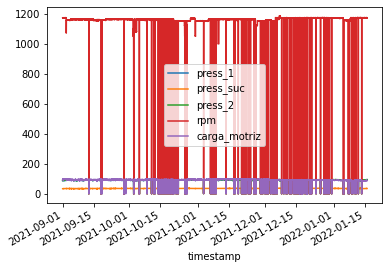

In [116]:
# x_compat=True mejora la forma en que se muestran las fechas
df_hist[(df_hist.element=='k-01') & (df_hist.timestamp > '2021-09-01')].plot(x='timestamp', x_compat=True);

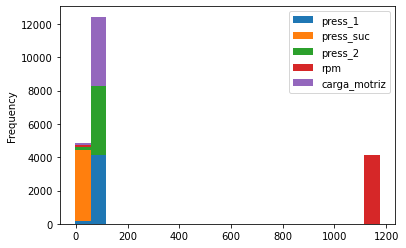

In [85]:
#df_hist[(df_hist.element=='k-01') & (df_hist.timestamp > '2022-01-01')].plot.density(x='timestamp', y='press_1');
df_hist[(df_hist.element=='k-01') & (df_hist.timestamp > '2022-01-01')].plot.hist(x='timestamp', stacked=True, bins=20);# , alpha=0.5); #, y=['press_1', 'press_suc']);

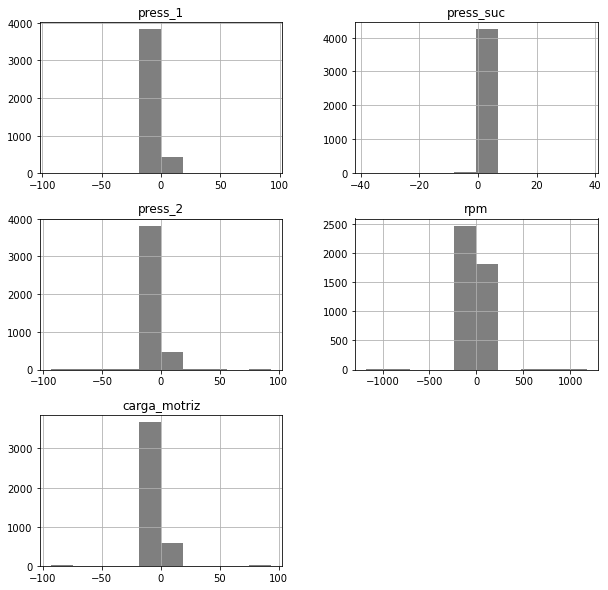

In [99]:
#df_hist[1:-1, (df_hist.element=='k-01') & (df_hist.timestamp > '2022-01-01')].diff().hist(color="k", alpha=0.5, bins=50);
df_hist.loc[(df_hist.element=='k-01') & (df_hist.timestamp > '2022-01-01'), list(df_hist.columns[1:-1])].\
            diff().hist(color="k", alpha=0.5, figsize=(10, 10));

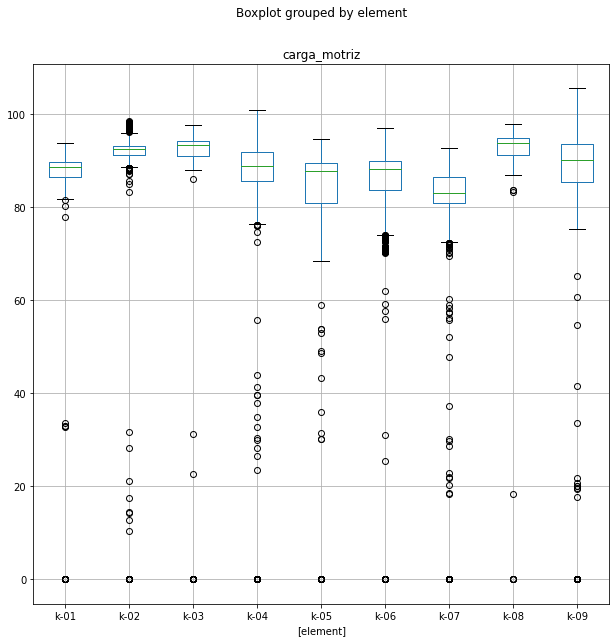

In [112]:
bp = df_hist.loc[(df_hist.timestamp > '2022-01-01') & (df_hist.carga_motriz >= 0), 
                 ['carga_motriz', 'element']].boxplot(by='element', figsize=(10, 10))

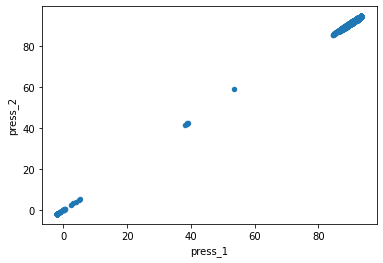

In [118]:
df_hist[(df_hist.element=='k-01') & (df_hist.timestamp > '2022-01-01')].plot.scatter(x='press_1', y='press_2'); # Esto no funcionó: c='element', colormap='viridis');

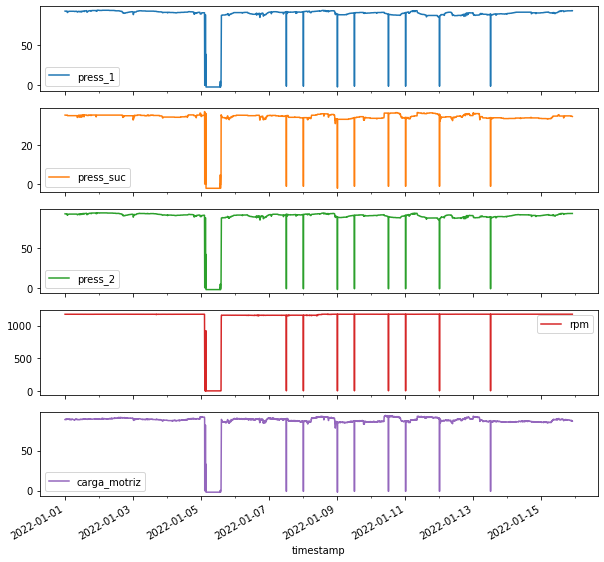

In [125]:
df_hist.loc[(df_hist.element=='k-01') & (df_hist.timestamp > '2022-01-01'), list(df_hist.columns[:-1])].\
            plot(x='timestamp', subplots=True, figsize=(10, 10), x_compat=True);

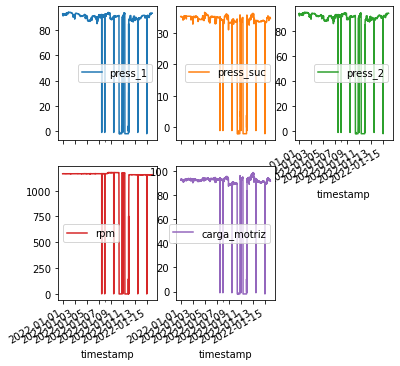

In [124]:
df_hist.loc[(df_hist.element=='k-02') & (df_hist.timestamp > '2022-01-01'), list(df_hist.columns[:-1])].\
            plot(x='timestamp', subplots=True, layout=(2, 3), figsize=(6, 6), x_compat=True);